In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import os
import psycopg2
from sklearn.neighbors import NearestNeighbors

In [3]:
def connect_to_database():
    # Get the database configuration from environment variables
    dbname_var = os.getenv('DB_NAME')
    user_var = os.getenv('DB_USER')
    password_var = os.getenv('DB_PASSWORD')
    host_var = os.getenv('DB_HOST')
    port_var=os.getenv('DB_PORT')

    conn= psycopg2.connect(dbname=dbname_var, user=user_var, password=password_var, host=host_var, port=port_var)  #
    cur= conn.cursor()

    return conn, cur

def close_database(conn, cur):
    conn.close()
    cur.close()

def get_latitude_longitude(cur, port_code='US LGB'):

    get_lat_lon= """select latitude, longitude from port_coordinates where un_locode = %s;"""
    cur.execute(get_lat_lon, (port_code,))
    latitude, longitude = cur.fetchone()
    return latitude, longitude

def get_ships_in_vicinity(cur, latitude, longitude, width, height):

    '''
    This function returns a dataframe of ships in the bounding box of a given set of coordinates.
    '''
    #Additional Information:
    #-The NAIS website lists all vessel types between 70 and 79, inclusive, as cargo ships.
    #-Most ships are stationary, therefore, the query averages the latitude and longitude 
    #of the vessels in the bounding box to obtain a singular latitude and longitude per vessel.

    get_ships_in_vicinity= """select base_date_time, imo, vessel_name, avg(lat), avg(lon) from ais_data 
    where lat >= %s and lat<= %s
    and lon between %s and %s and 
    vessel_type>69 and vessel_type <80
    group by 1,2,3
    """
    cur.execute(get_ships_in_vicinity, (latitude-height, latitude+height, longitude- width, longitude+ width))
    ships_in_vicinity_df = pd.DataFrame(cur.fetchall(), columns=['datetime', 'imo', 'vessel_name', 'latitude', 'longitude'])
    return ships_in_vicinity_df

def get_all_ports(cur):
    get_all_ports= """select main_port_name, latitude, longitude from port_coordinates;"""
    cur.execute(get_all_ports)
    ports_df= pd.DataFrame(cur.fetchall(), columns=['port_name', 'latitude', 'longitude'])
    return ports_df 



The widest distance covered by a degree of latitude and a degree of longitude is 111 km.
This means that no bounding box will be more than 1 degree in width or height.
Let's first plot the ships 1 degree around Long Beach, and then plot the ports in the same radius.

In [4]:
radius= 1

conn, cur= connect_to_database()
latitude, longitude= get_latitude_longitude(cur, 'US LGB')
ships_df= get_ships_in_vicinity(cur, latitude, longitude, radius, radius)
ports_df= get_all_ports(cur)
close_database(conn, cur)

In [5]:
#Let's look at the ports closest to Long Beach Port.
#We'll use the same radius that we did to get the ships in the vicinity.

ports_df_filtered= ports_df[(ports_df['latitude']>=latitude-radius) & \
                            (ports_df['latitude']>=longitude+radius) & \
                            (ports_df['longitude']>=longitude-radius) & \
                                (ports_df['longitude']<=longitude +radius)]

In [6]:
ports_df_filtered

,port_name,latitude,longitude
190,Isthmus Cove,33.450000,-118.500000
463,Avalon,33.350000,-118.316667
1009,Newport Beach,33.616667,-117.900000
1011,El Segundo,33.916667,-118.433333
1087,Wilson Cove,33.000000,-118.550000
1634,Los Angeles,33.750000,-118.250000
1635,Long Beach,33.766667,-118.183333


In [7]:
#Plot the ports and ships in the vicinity on a map for a specific date.

ships_df_filtered= ships_df[ships_df['datetime'].dt.date == pd.Timestamp('2020-01-02').date()]

fig = px.scatter_geo()
fig.add_scattergeo(
    lat=ships_df_filtered['latitude'],
    lon=ships_df_filtered['longitude'],
    text=ships_df_filtered['vessel_name'],
    mode='markers',
    marker=dict(color='blue', size=3),
    name='Vessels Around Long Beach'
)
fig.add_scattergeo(
    lat=ports_df_filtered['latitude'],
    lon=ports_df_filtered['longitude'],
    text=ports_df_filtered['port_name'],
    mode='markers',
    marker=dict(color='red', size=5, symbol='triangle-up'),
    name='Ports Nearby'
)
fig.update_layout(
    title='Ship and Port Locations',
    title_x=0.5,
    showlegend=True,
    geo=dict(
        scope='usa',
        projection_type='albers usa',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)"
       
    )
     
)
fig.show()



Let us assign the nearest port to all the vessels in this 1 degree radius using KNN with K=1.
Then we will filter to vessels that have been assigned the port Long Beach.
Once that is complete, we will analyze the density/distribution of the ships to determine the bounding box.
The assumption is that there will be a greater density of vessels around the port than farther away.

In [ ]:
# Extract coordinates
ports_coordinates = ports_df_filtered[['latitude', 'longitude']].values
ships_coordinates = ships_df_filtered[['latitude', 'longitude']].values

# Fit NearestNeighbors model for Eucledian Distance
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(ports_coordinates)

# Find the nearest port for each ship
distances, indices = nbrs.kneighbors(ships_coordinates)

# Add the nearest port information to ships_df_filtered
ships_df_filtered['nearest_port'] = ports_df_filtered.iloc[indices.flatten()]['port_name'].values
ships_df_filtered['distance_to_port'] = distances.flatten()



In [9]:
long_beach_ships= ships_df_filtered[ships_df_filtered['nearest_port']=='Long Beach']

other_ships = ships_df_filtered[ships_df_filtered['nearest_port']!='Long Beach']


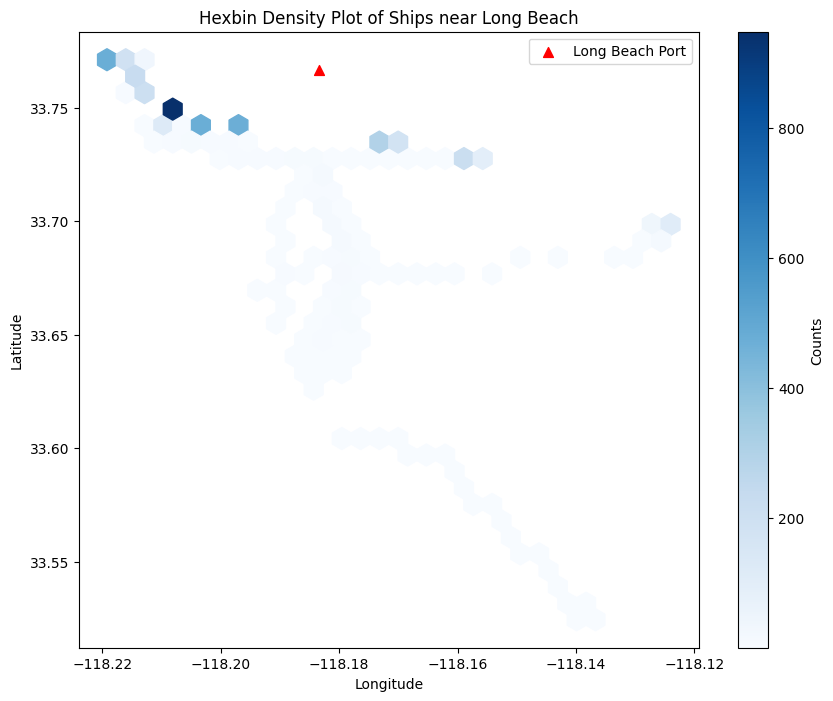

In [10]:
# Plot hexbin
plt.figure(figsize=(10, 8))

hb = plt.hexbin(long_beach_ships['longitude'], long_beach_ships['latitude'], gridsize=30, cmap='Blues', mincnt=1)
plt.colorbar(hb, label='Counts')


'''hb2 = plt.hexbin(other_ships['longitude'], other_ships['latitude'], gridsize=200, cmap='Greens', mincnt=1)
plt.colorbar(hb2, label='Counts')'''


# Mark Long Beach port on the plot
plt.scatter(longitude, latitude, color='red', s=50, label='Long Beach Port', marker='^')

# Labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hexbin Density Plot of Ships near Long Beach')
plt.legend()

# Show plot
plt.show()

In [11]:
# Extract hexbin information
counts = hb.get_array()
verts = hb.get_offsets()

# Calculate the centers of the hexbins
hexbin_lons = verts[:, 0]
hexbin_lats = verts[:, 1]

# Create a DataFrame for hexbin centers and counts
hexbin_df = pd.DataFrame({'longitude': hexbin_lons, 'latitude': hexbin_lats, 'counts': counts})
hexbin_df = hexbin_df.sort_values(by=['counts'],ascending=[False])

print(hexbin_df)

      longitude   latitude  counts
68  -118.208097  33.749466   948.0
0   -118.219200  33.771250   477.0
8   -118.203338  33.742204   477.0
11  -118.196994  33.742204   472.0
100 -118.173201  33.734943   298.0
..          ...        ...     ...
48  -118.162098  33.596975     1.0
46  -118.165270  33.596975     1.0
44  -118.168443  33.596975     1.0
92  -118.179546  33.705897     1.0
58  -118.143064  33.684112     1.0

[117 rows x 3 columns]


In [12]:
print (latitude - 33.734943) #length
print (longitude + 118.219200) #width

0.03172399999999698
0.035866999999996096


Based on the density plot and density centres, the width in degrees of longitude is 0.035866, and the height in degrees of latitude is 0.041723.

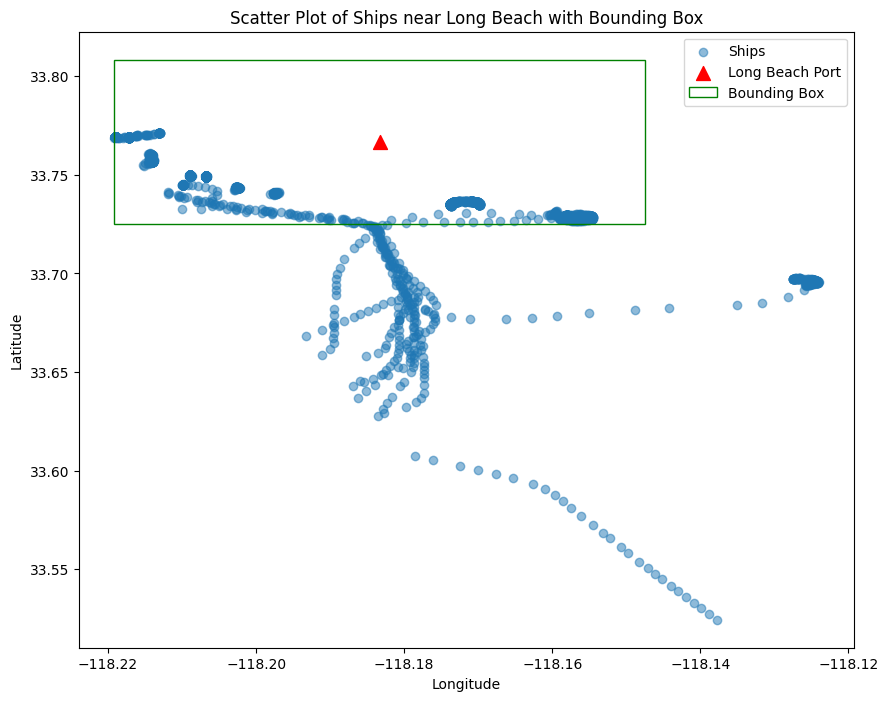

In [13]:
height = 0.041723  
width = 0.035866  #for the bounding box

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(long_beach_ships['longitude'], long_beach_ships['latitude'], alpha=0.5, label='Ships')

# Plot the red triangle for the specified coordinates
plt.scatter(longitude, latitude, color='red', s=100, label='Long Beach Port', marker='^')

# Draw the rectangle for the bounding box
rect = plt.Rectangle(
    (longitude - width, latitude - height),  #bottom-left corner
    2 * width,  
    2 * height,  
    linewidth=1,
    edgecolor='green',
    facecolor='none',
    label='Bounding Box'
)
plt.gca().add_patch(rect)

# Labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Ships near Long Beach with Bounding Box')
plt.legend()

# Show plot
plt.show()
